In [91]:
import sys 
import os

# Add the parent directory to the path if it's not already there
if os.path.abspath('..') not in sys.path:
    sys.path.append(os.path.abspath('..'))

In [92]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
from ddql_optimal_execution import DDQL, MarketEnvironnement, Trainer, TWAP
import matplotlib.pyplot as plt

In [105]:
env = MarketEnvironnement(initial_inventory=500, multi_episodes=True)

In [106]:
agent = DDQL(state_size=env.state_size, initial_budget=env.initial_inventory, horizon=env.horizon)

Using cpu device


In [107]:
trainer = Trainer(agent, env, capacity=10000)

In [110]:
trainer.fill_exp_replay(max_steps=1000)

Output()

In [15]:
trainer.pretrain(max_steps=1000, batch_size=32)

tensor([-1.6128, -1.6181,    -inf,    -inf, -1.6216,    -inf, -1.6088, -1.6200,
        -1.6147, -1.6043, -1.6127,    -inf, -1.6064, -1.6171, -1.6140, -1.6056,
           -inf, -1.6176, -1.6169, -1.6090, -1.6188, -1.6252, -1.6137, -1.6096,
        -1.6149, -1.6137, -1.6104, -1.6116, -1.6244,    -inf, -1.6181, -1.6180],
       grad_fn=<IndexBackward0>)
tensor([   -inf, -6.7516, -6.7361, -6.7220, -6.7242, -6.7416, -6.7354, -6.7659,
        -6.7438, -6.7516,    -inf,    -inf,    -inf, -6.7302,    -inf, -6.7360,
        -6.7418,    -inf, -6.7281, -6.7271, -6.7484, -6.7548, -6.7458, -6.7354,
        -6.7455,    -inf, -6.7550, -6.7397, -6.7474, -6.7115, -6.7415,    -inf],
       grad_fn=<IndexBackward0>)
tensor([-17.5037, -17.4453, -17.4953,     -inf, -17.4686, -17.4900, -17.4695,
        -17.4728, -17.4659,     -inf, -17.4375,     -inf, -17.4739, -17.5148,
        -17.4448, -17.5067,     -inf, -17.4230, -17.4568, -17.5110, -17.4649,
            -inf, -17.4845, -17.4976, -17.4466, -17.4711, 

In [16]:
st = trainer.env.state.copy()

In [17]:
from rich import print  

In [102]:
trainer.agent.greediness = .1

In [107]:
print(trainer.agent(state=st))

None

In [46]:
trainer.train(max_steps=10000, batch_size=128)

tensor([ -38.3100,  405.8012, -284.3542,  637.7474, -104.8583,  -88.8756,
             -inf,  425.3899, -409.8212,      -inf,  -67.7501,  -48.1093,
             -inf,  213.1559,  798.0922,      -inf,  219.2731,  370.3078,
         569.7014, -296.9803,  173.6213,  -88.8527, -175.2924,      -inf,
         230.3878,  112.7964, 1174.2340,  -25.5043,      -inf, -444.0372,
         611.4361,  117.8467], grad_fn=<IndexBackward0>)
tensor([-415.8391, -120.9075,   50.2588, -166.9070,  272.2562,  274.5400,
         -54.1997, -333.8721,  192.9213,      -inf,  316.7427,  536.9351,
        -178.1839, -358.1668, -323.7483,      -inf, -209.8796,  542.3524,
          55.1492, -120.9291, -584.1102,      -inf, -392.3134,      -inf,
        -518.9814,  -20.7979,      -inf,  126.0992,  292.8955,  346.6946,
        -104.5429,  542.3524], grad_fn=<IndexBackward0>)
tensor([-246.6125, -556.9825,   76.1243,   36.8882,   94.4050,  155.8175,
        -195.4357,  393.5505,  -28.5829,  588.2480,      -inf,  232.7552

In [ ]:
import seaborn as sns

In [47]:
trainer.env.reset()

In [49]:
while not trainer.env.done:
    act = trainer.agent.get_action(trainer.env.state)
    trainer.env.step(act)
    plt.plot(trainer.agent.target_net(trainer.env.state).detach().numpy().clip(-100, 100))
    plt.show()
    print(act)
    print(trainer.env.state)



In [86]:
#test the agent
pnl= {'twap':[], 'ddql':[]}
env.reset()

twap = TWAP(initial_budget=env.initial_inventory, horizon=env.horizon)

pnl_twap = []
pnl_ddql = []

for ep in range(100):
    env.swap_episode(ep)
    _pnl_twap = [0]
    while not env.done:
        current_state = env.state.copy()
        action = twap(current_state)
        print(action)
        _ = env.step(action)
        _pnl_twap.append(env.state['Price']*action)
    pnl_twap.append(_pnl_twap)

    env.reset()
    _pnl_ddql = [0]
    while not env.done:
        current_state = env.state.copy()
        action = trainer.agent(current_state)
        print(action)
        _ = env.step(action)
        _pnl_ddql.append(env.state['Price']*action)
    pnl_ddql.append(_pnl_ddql)









100

100

100

100

0

0

0

159

100

100

100

100

159

0

86

86

100

100

100

100

159

159

1

0

100

100

100

100

0

0

0

159

100

100

100

100

86

86

0

0

100

100

100

100

0

0

0

0

100

100

100

100

0

0

86

350

100

100

100

100

86

86

0

86

100

100

100

100

86

159

159

1

100

100

100

100

0

86

0

86

100

100

100

100

0

0

0

0

100

100

100

100

86

0

0

159

100

100

100

100

0

0

0

86

100

100

100

100

86

0

0

0

100

100

100

100

86

0

0

86

100

100

100

100

1

159

0

0

100

100

100

100

0

0

86

86

100

100

100

100

86

0

0

1

100

100

100

100

1

425

1

1

100

100

100

100

0

86

0

0

100

100

100

100

86

350

0

0

100

100

100

100

159

159

1

159

100

100

100

100

1

86

0

0

100

100

100

100

86

86

1

0

100

100

100

100

86

0

0

0

100

100

100

100

159

0

86

0

100

100

100

100

0

0

0

86

100

100

100

100

159

159

1

0

100

100

100

100

0

0

0

0

100

100

100

100

0

0

350

1

100

100

100

100

86

350

1

0

100

100

100

100

0

0

425

1

100

100

100

100

0

0

159

159

100

100

100

100

86

86

86

1

100

100

100

100

0

0

86

159

100

100

100

100

0

86

86

86

100

100

100

100

86

159

0

159

100

100

100

100

0

0

159

159

100

100

100

100

1

159

1

0

100

100

100

100

0

0

0

1

100

100

100

100

86

159

0

86

100

100

100

100

0

0

0

159

100

100

100

100

0

0

0

86

100

100

100

100

159

86

1

0

100

100

100

100

0

0

159

86

100

100

100

100

86

0

159

0

100

100

100

100

0

0

86

159

100

100

100

100

0

0

159

86

100

100

100

100

159

1

86

0

100

100

100

100

0

0

0

0

100

100

100

100

0

159

159

86

100

100

100

100

0

86

0

350

100

100

100

100

350

1

1

1

100

100

100

100

0

425

1

1

100

100

100

100

0

0

0

159

100

100

100

100

0

86

0

0

100

100

100

100

1

159

0

0

100

100

100

100

0

0

86

86

100

100

100

100

159

86

159

1

100

100

100

100

0

0

0

86

100

100

100

100

0

0

0

86

100

100

100

100

0

0

159

1

100

100

100

100

0

86

159

159

100

100

100

100

0

350

46

0

100

100

100

100

0

159

159

0

100

100

100

100

0

86

350

1

100

100

100

100

159

0

0

0

100

100

100

100

0

0

86

1

100

100

100

100

86

0

86

1

100

100

100

100

1

1

0

86

100

100

100

100

0

0

0

86

100

100

100

100

159

159

0

0

100

100

100

100

0

0

0

0

100

100

100

100

1

86

0

86

100

100

100

100

86

159

0

159

100

100

100

100

0

0

159

159

100

100

100

100

0

0

3

0

100

100

100

100

159

0

86

1

100

100

100

100

86

86

86

0

100

100

100

100

86

159

0

1

100

100

100

100

425

1

0

0

100

100

100

100

0

0

425

1

100

100

100

100

0

86

86

159

100

100

100

100

0

86

0

0

100

100

100

100

0

0

0

1

100

100

100

100

0

0

159

159

100

100

100

100

86

159

1

86

100

100

100

100

0

0

0

86

100

100

100

100

159

159

1

0

100

100

100

100

86

1

159

159

100

100

100

100

0

0

0

425

100

100

100

100

159

159

1

0

100

100

100

100

0

0

0

0

100

100

100

100

0

0

1

86

100

100

100

100

159

86

86

1

100

100

100

100

0

0

0

86

100

100

100

100

425

1

1

1

100

100

100

100

86

159

1

86

100

100

100

100

159

1

86

0

100

100

100

100

0

86

86

159

In [79]:
import numpy as np
plt.rcParams['text.usetex'] = False


In [87]:
pnl_ddql, pnl_twap = np.array(pnl_ddql), np.array(pnl_twap)

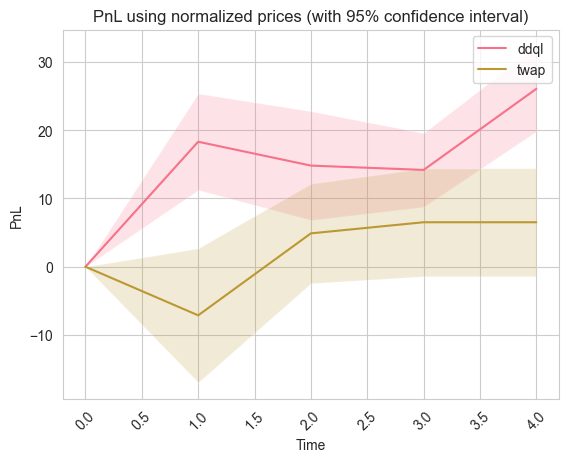

In [90]:
confidence_level = .95

# time_ = env.historical_data
# time_ = time_.groupby(time_.period).nth(0).index

plt.plot(pnl_ddql.mean(axis=0), label='ddql')
plt.fill_between(range(len(pnl_ddql.mean(axis=0))), pnl_ddql.mean(axis=0)-confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), pnl_ddql.mean(axis=0)+confidence_level*pnl_ddql.std(axis=0)/np.sqrt(len(pnl_ddql)), alpha=.2)
plt.plot(pnl_twap.mean(axis=0), label='twap')
plt.fill_between(range(len(pnl_twap.mean(axis=0))), pnl_twap.mean(axis=0)-confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), pnl_twap.mean(axis=0)+confidence_level*pnl_twap.std(axis=0)/np.sqrt(len(pnl_twap)), alpha=.2)
plt.legend()
plt.xticks(rotation=45)

plt.title(r'PnL using normalized prices (with 95% confidence interval)')
plt.xlabel('Time')
plt.ylabel('PnL')
plt.show()

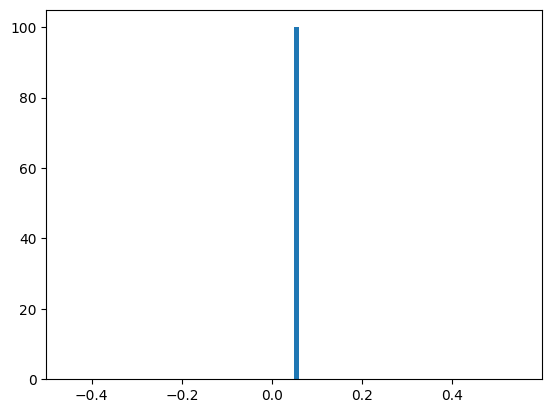

NameError: name 'np' is not defined

In [11]:
#distribution of rewards
plt.hist(rewards, bins=100, density=True)
plt.show()

print(f"mean reward: {np.mean(rewards)}")
print(f"std reward: {np.std(rewards)}")

In [6]:

# Draft Martial

import pandas as pd
import numpy as np

def fake_data(S : float = 100, r : float = 0.1, sigma : float = 0.2, start='2022-01-01 11:00:01', end='2022-01-01 13:00:00'):
    # Creation of the dataset output
    data = pd.DataFrame(pd.date_range(start=start, end=end,  freq = "s"), columns=['Date'])
    num_points, _ = np.shape(data)

    # Simulate a Black-Scholes trajectory
    dt = 1/252/6.5/3600 # scale of a second
    drift = (r - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt) * np.random.normal(size=num_points - 1)
    log_returns = np.concatenate([[0], drift + diffusion])
    log_prices = np.cumsum(log_returns)
    prices = S * np.exp(log_prices)
    
    data["Price"] = prices
    data.set_index('Date', inplace=True)


    return data


In [7]:
for i in range(100):
    fake_data(start="2022-01-01 11:00:01", end="2022-01-01 12:00:00").to_csv(f"../data/fake_data_{i}.csv")
    fake_data(start="2022-01-01 12:00:01", end="2022-01-01 13:00:00").to_csv(f"../data/fake_data_{i+100}.csv")
    fake_data(start="2022-01-01 13:00:01", end="2022-01-01 14:00:00").to_csv(f"../data/fake_data_{i+200}.csv")